# GPU Acceleration in Scikit-learn

*Scikit-learn* is a widely used Python library for machine learning, known for its simplicity and efficiency in implementing various algorithms.<br>
While Scikit-learn is fast, there is always potential for further optimization to enhance speed and reduce execution time.<br>

### Current State of GPU Utilization in Scikit-Learn
*Scikit-learn* does not natively support GPU acceleration for most of its algorithms.
The primary reasons for this are:<br>
**1. Software Dependencies:** Introducing GPU support would require additional software dependencies and hardware-specific configurations, complicating the installation and maintenance process for users and developers.
 <br>
**2. Algorithmic Constraints:** Many of the algorithms in scikit-learn are implemented and optimized for CPU-based computations. Adapting these algorithms to take advantage of GPU processing would require substantial modifications and might not always lead to performance improvement.<br>
**3. Design Constraints:** *Scikit-learn* is designed to provide a unified API for basic machine learning tasks. Introducing GPU support would require a significant redesign of the package, potentially increasing its complexity and making it harder to maintain.
                                                                                                                                         
                                                         

### Enabling GPU Support in Scikit-Learn
1. Using Intel Extension for Scikit-learn<br>
2. Using Rapids cuML (Nvidia)


## Using Rapids cuML (Nvidia)
**Rapids** - an open-source data analytics and machine learning acceleration platform created by Nvidia <br>
* leverages GPUs to accelerate computations<br>
* based on Python, has pandas-like and Scikit-Learn-like interfaces<br>
* built on Apache Arrow in-memory data format<br>
* can scale from 1 to multi-GPU to multi-nodes<br>


Clone the project repository into your home directory:<br>
git clone https://github.com/argonne-lcf/ALCF_Hands_on_HPC_Workshop/ <br>
cd /ALCF_Hands_on_HPC_Workshop/Scikit-learn

### Start a Dask-RAPIDS cluster on Polaris
1. ssh into one of Polaris' login nodes <br>
`ssh username@polaris.alcf.anl.gov` <br>
2. ##### <a href='https://docs.alcf.anl.gov/polaris/running-jobs/' target="_blank">Submit an interactive job</a> on n (here 1) nodes 
    `qsub -l select=1:system=polaris -l filesystems=home:eagle:grand -l walltime=00:30:00 -I -A YourProject -q YourQueue` <br>
A shell opens up on one of the compute nodes <br>
3. Load the `dask_rapids` module <br>
   `module use /soft/modulefiles`<br>
   `module load dask_rapids/2024-10-15`
4. Run the script, `start_daskmpi_polaris.sh`. This will start the scheduler on one node.<br>
In case of errors or if the cluster does not start, check the file `~/dask-local-directory/scheduler.json` and the log files of scheduler and workers in `~/dask-local-directory/logs/`


### Access the cluster from JupyterLab
1. Start a RAPIDS cluster
2. Establish a <a href="https://en.wikibooks.org/wiki/OpenSSH/Cookbook/Multiplexing" target='plain'>Multiplexed SSH Connection</a> to Polaris. Run the code below in your local machine, ensure to edit `YourUsername`<br>
`ssh -M -S ~/.ssh/multiplex:polaris.rapids YourUsername@polaris.alcf.anl.gov`
3. On a different terminal window in your local machine, run the script open_jupyterlab_polaris.sh to start a JupyterLab session on Polaris<br>
`./open_jupyterlab_polaris.sh <COMPUTE_NODE_ADDRESS>` <br>
where `<COMPUTE_NODE_ADDRESS>` is the compute node hostname, like `x3006c0s1b1n0`<br>
4. Copy the url that is returned by the script and paste it in a browser window to access JupyterLab and view the dashboards <br>
5. If it issued an ssh connection with control master error, open the script and replace `polaris` with <br>
`YourUsername@polaris.alcf.anl.gov`

### On JupyterLab
Select the kernel with your RAPIDS' eniroment name (something like Python `[conda env:rapids-23.04_polaris]`) from the Kernel menu in the top right corner.<br>
if the RAPIDS' kernel is not present in the kernel menu, add it by activating the conda environment running the commands (run each line separately):<br>
`source activate_rapids_env_polaris.sh env=$(basename `echo $CONDA_PREFIX`)`<br>
`python -m ipykernel install --user --name "$env" --display-name "Python [conda env:"$env"]"`<br>
Select and access the dashboards from the bar on the left side

### Accessing Project Folders
To access project directories located outside of your `$HOME`, a symbolic link to the directory must be created.<br>
**from terminal**<br>
cd ~
`ln -s /ALCF_Hands_on_HPC_Workshop/Scikit-learn`

**in notebook using `!` escape** <br>
`!ln -s /ALCF_Hands_on_HPC_Workshop/Scikit-learn`



### On Jupyter Notebook, Connect to the cluster with:

In [1]:
from dask.distributed import Client, wait
import dask.distributed
import json
import pathlib
fname = f'{pathlib.Path.home().as_posix()}/dask-local-directory/scheduler.json'
with open(fname, 'r') as f:
    scheduler = json.load(f)
    client = dask.distributed.Client(scheduler['address'])
client

<Client: 'tcp://10.201.1.253:8786' processes=31 threads=31, memory=15.23 TiB>

### GPU Accelerated DBSCAN in RAPIDS

In [2]:
# Import the neccessary libraries
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import cudf
#import dask_cudf
from cuml.cluster import DBSCAN as cumlDBSCAN
import time
import matplotlib.pyplot as plt
%matplotlib inline

**Generate Dataset**

In [3]:
# Generate synthetic data using make_blobs
centers = [[0, 0], [0, 1]]
X, _ = make_blobs(n_samples=150000, centers=centers, cluster_std=0.1, random_state=0)


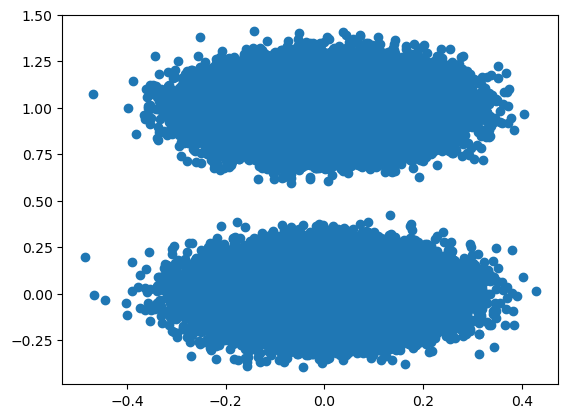

In [4]:
# Let's visualize our dataset
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [5]:
# Convert data to cuDF DataFrame for GPU
X_df=pd.DataFrame(X)
X_gpu = cudf.DataFrame.from_pandas(X_df)


In [7]:
# Run DBSCAN on GPU using cuML
start_time = time.time()
db_gpu = cumlDBSCAN(eps=0.2, min_samples=20).fit(X_gpu, out_dtype='int64')
gpu_time = time.time() - start_time
print(f"DBSCAN on GPU took: {gpu_time:.4f} seconds")

DBSCAN on GPU took: 1.0296 seconds


In [8]:
# Run DBSCAN on CPU using scikit-learn
start_time = time.time()
db_cpu = DBSCAN(eps=0.2, min_samples=20).fit(X)
cpu_time = time.time() - start_time
print(f"DBSCAN on CPU took: {cpu_time:.4f} seconds")

DBSCAN on CPU took: 56.6901 seconds


In [7]:
# Compare results 
cpu_labels = db_cpu.labels_
gpu_labels = db_gpu.labels_.to_pandas().values
silhouette_gpu = silhouette_score(X, gpu_labels)
print(f'Silhouette Score (GPU): {silhouette_gpu:.4f}')

silhouette_cpu = silhouette_score(X, cpu_labels)
print(f'Silhouette Score (CPU): {silhouette_cpu:.4f}')

Silhouette Score (GPU): 0.8226
Silhouette Score (CPU): 0.8226



### Shutdown the cluster with: 
`client.shutdown()`<br>
Then run the script `close_jupyterlab_polaris.sh` on your local machine to end the JupyterLab session and close the multiplexed connection<br>
Make sure to edit `YourUsername` on the script